Data Sources:
- Organization for Economic Co-operation and Development, National Currency to US Dollar Exchange Rate: Average of Daily Rates for Sweden [CCUSMA02SEQ618N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CCUSMA02SEQ618N, February 23, 2023.
- OECD (2023), Short-term interest rates (indicator). doi: 10.1787/2cc37d77-en (Accessed on 23 February 2023)
(all others also from OECD)

### Loading, preparing and plotting time series

In [2]:
library(readxl)
library(urca)
library(vars)
library(tseries)
library(forecast)
library(tidyverse)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ stringr::boundary() masks strucchange::boundary()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::select()     masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [23]:
# load the "merged" csv data
raw_file <- read_csv("Data_Sweden/merged.csv")

Rows: 163 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (4): EXR, FED, CPI, GDP
date (1): TIME

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [24]:
# view raw table
str(raw_file)

spc_tbl_ [163 × 5] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ EXR : num [1:163] 5.74 5.9 6.16 7.33 7.41 ...
 $ TIME: Date[1:163], format: "1982-01-01" "1982-04-01" ...
 $ FED : num [1:163] 12.3 13 14.4 13.3 11.1 ...
 $ CPI : num [1:163] 9.03 8.58 7.84 8.92 8.71 ...
 $ GDP : num [1:163] 0.284 2.112 -1.241 1.948 -1.131 ...
 - attr(*, "spec")=
  .. cols(
  ..   EXR = col_double(),
  ..   TIME = col_date(format = ""),
  ..   FED = col_double(),
  ..   CPI = col_double(),
  ..   GDP = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [25]:
# declare time series variables
gdp <- ts(raw_file$GDP, start = c(1960,4), frequency = 4)
exr <- ts(raw_file$EXR, start = c(1960,4), frequency = 4)
cpi <- ts(raw_file$CPI, start = c(1960,4), frequency = 4)
fed <- ts(raw_file$FED, start = c(1960,4), frequency = 4)

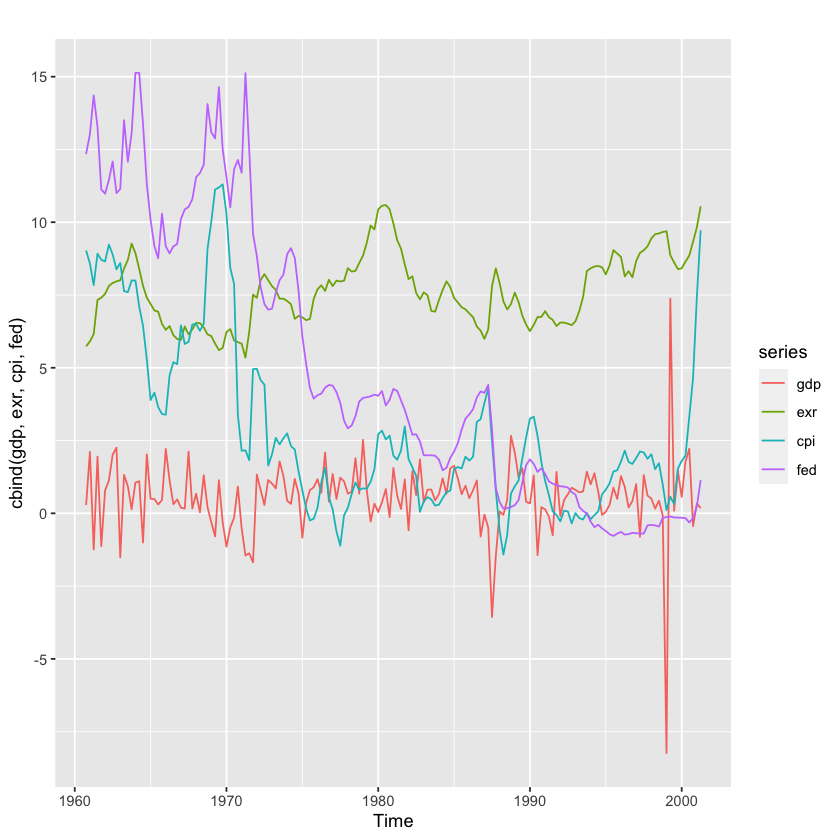

In [26]:
# plot each time series
autoplot(cbind(gdp, exr, cpi, fed))


All except GDP need to be first differenced!

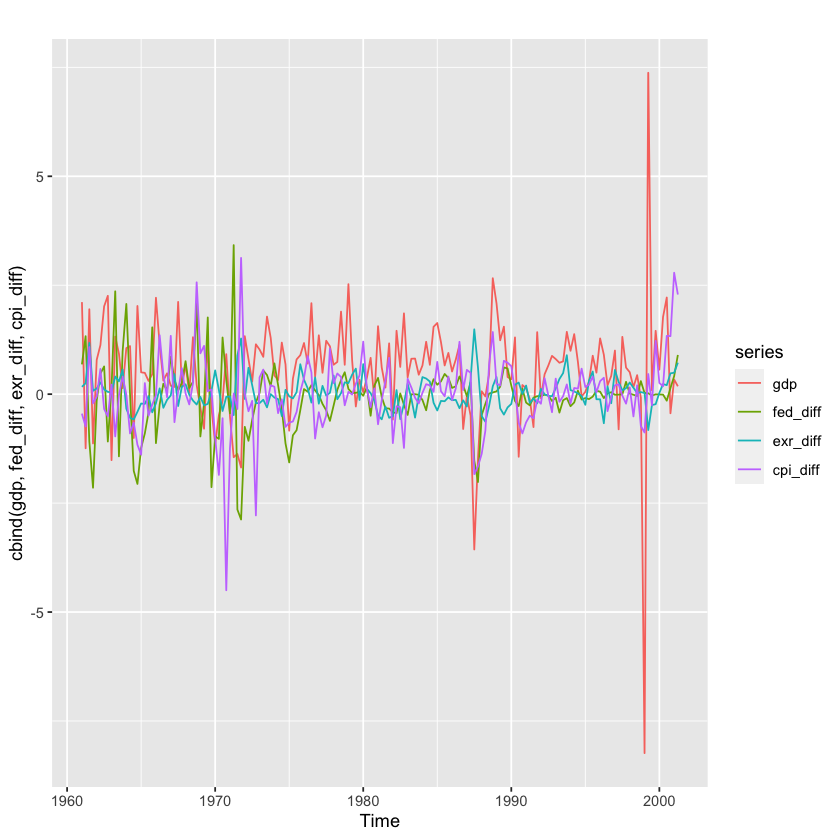

In [30]:
# take first differences of all but gdp
fed_diff <- diff(fed, differences = 1)
exr_diff <- diff(exr, differences = 1)
cpi_diff <- diff(cpi, differences = 1)
# drop first observation of gdp to make all series same length
gdp <- gdp[-1]

autoplot(cbind(gdp, fed_diff, exr_diff, cpi_diff))

These look stationary.

### Cross Sectional Checks

In [31]:
# running OLS of growth on fed_diff

ols1 <- lm(gdp ~ fed_diff)
summary(ols1)


Call:
lm(formula = gdp ~ fed_diff)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8197 -0.4780  0.0474  0.6127  6.7939 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.57658    0.09963   5.787 3.67e-08 ***
fed_diff     0.22276    0.12471   1.786    0.076 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.263 on 160 degrees of freedom
Multiple R-squared:  0.01955,	Adjusted R-squared:  0.01342 
F-statistic: 3.191 on 1 and 160 DF,  p-value: 0.07596


In [32]:
# running cpi on fed_diff

ols2 <- lm(cpi_diff ~ fed_diff)
summary(ols2)


Call:
lm(formula = cpi_diff ~ fed_diff)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5673 -0.4067  0.0423  0.3540  3.5715 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.01536    0.06742   0.228   0.8201  
fed_diff     0.16003    0.08439   1.896   0.0597 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8548 on 160 degrees of freedom
Multiple R-squared:  0.02198,	Adjusted R-squared:  0.01587 
F-statistic: 3.596 on 1 and 160 DF,  p-value: 0.05971


Bad fits and insignificant coefficients, though gdp has positive intercept (good sign...)

### Problem Set Questions

Structural model:

$$Bx_t = \Gamma_0 + \Gamma_1 x_{t-1} + \epsilon_t$$

Where the reduced form is:

$$x_t = B^{-1}\Gamma_0 + B^{-1}\Gamma_1 x_{t-1} + B^{-1} \epsilon_t$$

such that 

$$e_t = B^{-1} \epsilon_t \: \rightarrow \: Be_t = \epsilon_t$$

In the SVAR, we restrict matrix B such that we are able to identify our $\frac{n^2-n}{2} = 6$ parameters, where NA is to estimated:

$$B = \begin{bmatrix}
1 & 0 & 0 & 0\\
NA & 1 & 0 & 0 \\
NA & NA & 1 & 0 \\
NA & NA & NA & 1
\end{bmatrix}$$

In [87]:
# building structural VAR model with restrictions:

sVar <- cbind(cpi_diff, gdp, fed_diff, exr_diff) # order matters
colnames(sVar) <- cbind("CPI", "GDP", "FED", "EXR")

amat <- diag(4)
amat[2,1] <- NA
amat[3,1] <- NA
amat[3,2] <- NA
amat[4,1] <- NA
amat[4,2] <- NA
amat[4,3] <- NA

# construct variance matrix with NA on diagonal to allow variances to differ: this will yield a just-identified model
bmat <- diag(4)
bmat[1,1] <- bmat[2,2] <- bmat[3,3] <- bmat[4,4] <- NA


In [88]:
lagselect <- VARselect(sVar, lag.max = 10, type = "const")
lagselect$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     9      1      1      9

I will rely on the Hannan–Quinn information criterion, and constrain myself to one lag.

In [89]:
# Johansen procedure to check for cointegration and stationarity
cajorls <- ca.jo(sVar, type = "trace", ecdet = "none", K = 2, spec="transitory", season = NULL, dumvar = NULL)
summary(cajorls)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.4301327 0.3567954 0.2501864 0.1652162

Values of teststatistic and critical values of test:

           test 10pct  5pct  1pct
r <= 3 |  28.89  6.50  8.18 11.65
r <= 2 |  74.96 15.66 17.95 23.52
r <= 1 | 145.57 28.71 31.52 37.22
r = 0  | 235.55 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

          CPI.l1      GDP.l1      FED.l1    EXR.l1
CPI.l1  1.000000  1.00000000  1.00000000 1.0000000
GDP.l1  1.133256 -1.86907161 -0.08225124 0.3181974
FED.l1 -5.921598  0.01215704 -0.53295882 0.5283561
EXR.l1  2.166008 -0.16922106 -3.03375516 1.8036968

Weights W:
(This is the loading matrix)

            CPI.l1      GDP.l1      FED.l1      EXR.l1
CPI.d -0.044928580 -0.11677888 -0.17899643 -0.27617159
GDP.d  0.001442775  0.50517669 -0.13923987 -0.25128488
FED.d  0.156687698 -0.04527711 -0.022640

The system is stationary.

In [90]:
# Estimating the Var with our restrictions:

model1 <- VAR(sVar, p = 1, type = "const", season = NULL, exog = NULL)
sVarModel <- SVAR(model1, Amat = amat, Bmat = bmat, hessian = TRUE, estmethod = c("scoring","direct"))
sVarModel

Warning message in SVAR(model1, Amat = amat, Bmat = bmat, hessian = TRUE, estmethod = c("scoring", :
“The AB-model is just identified. No test possible.”



SVAR Estimation Results:


Estimated A matrix:
         CPI     GDP    FED EXR
CPI  1.00000  0.0000 0.0000   0
GDP -0.23619  1.0000 0.0000   0
FED -0.09354 -0.0691 1.0000   0
EXR -0.05911  0.0601 0.1205   1

Estimated B matrix:
       CPI   GDP    FED    EXR
CPI 0.8222 0.000 0.0000 0.0000
GDP 0.0000 1.239 0.0000 0.0000
FED 0.0000 0.000 0.7818 0.0000
EXR 0.0000 0.000 0.0000 0.3204

- prices positively shock into GDP: $e_y = \epsilon_y - a_{21}\epsilon_p = \epsilon_y + 0.23619\epsilon_p$
- they shock negatively into the fed_rate: $-0.0691 * -0.23619 - -0.05911

Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
“The AB-model is just identified. No test possible.”
Warning messa

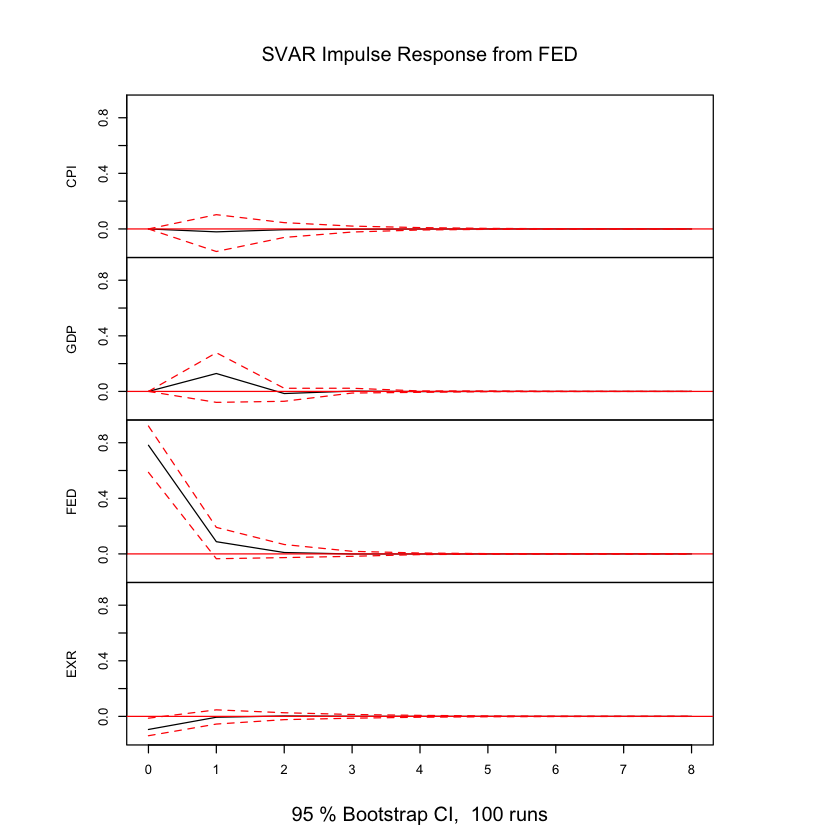

In [91]:
# impulse response functions for a one standard deviation shock to the interest rate FED

IRFs <- irf(sVarModel, impulse = "FED", n.ahead = 8)
plot(IRFs)

- The IRFs do not show significant effects except on the the FED, and the instantaneous drop in the exchange rate. 
- GDP has a delayed (we imposed no instantaneous effect) bump that recovers already after the first quarter
- Prices slightly give in but not significantly, there is no prize puzzle here.
- The exchange rate immediately gives in slightly (the Krona becomes more valuable, since 1$ can buy less Krona), but has a lot of upward sampling uncertainty.

**The estimated direction of movement of prices and the exchange rate is intuitive, that of GDP is not.**

If we believe our restriction, we are estimating:

$$x_t = \hat{B}^{-1}\Gamma_0 + \hat{B}^{-1}\Gamma_1 x_{t-1} + \hat{B}^{-1} \epsilon_t$$

with 
$$\hat{B}^{-1} = \begin{bmatrix}
1 & 0 & 0 & 0\\
-0.23619 & 1 & 0 & 0 \\
-0.09354 & -0.0691 & 1 & 0 \\
-0.05911 &  0.0601 & 0.1205 & 1
\end{bmatrix}
$$

So I suppose running a Granger causality test is like checking whether elements of $\hat{B}^{-1} \Gamma_1$ could be zero, which would imply that past values do not inform about present values?

The reduced form equation gives us an estimate of 
$$\hat{[B^{-1}\Gamma_1]}$$

From my understanding, the Granger causality test tells us nothing about the legitimacy of our restrictions. One is a purely data related check, the other lives in the world of a priori causal assumptions.

In [67]:
# Granger causality test on fed rate

causalityTest <- causality(model1, cause = "EXR")
causalityTest

$Granger

	Granger causality H0: EXR do not Granger-cause CPI GDP FED

data:  VAR object model1
F-Test = 0.90106, df1 = 3, df2 = 624, p-value = 0.4403


$Instant

	H0: No instantaneous causality between: EXR and CPI GDP FED

data:  VAR object model1
Chi-squared = 19.798, df = 3, p-value = 0.0001869



We do not reject H0 that says that there is no Granger causality from EXR. We assumed that exchange rate shocks are not instantenously transmitted into prices and GDP, but this does not rule out the possibility of contemporaneous response effects??

The fact that the instantaneous causality seems highly significant hints at the fact that there is unexplained correlation in our error terms, which hints at the fact that the model is misspecified, which is not surprising given that consider only 1 lag.

In [92]:
# redefining the sVar using new restrictions (I am changing the Choleski recursive ordering):
sVar_new <- cbind(fed_diff, cpi_diff, gdp, exr_diff) # new order: fed rate is not affected by other shocks
colnames(sVar_new) <- cbind("FED", "CPI", "GDP", "EXR")


amat_new <- diag(4)
amat_new[2,1] <- NA
amat_new[3,1] <- NA
amat_new[3,2] <- NA
amat_new[4,1] <- NA
amat_new[4,2] <- NA
amat_new[4,3] <- NA

In [93]:
model2 <- VAR(sVar_new, p = 1, type = "const", season = NULL, exog = NULL)
sVarModel_new <- SVAR(model2, Amat = amat_new, Bmat = bmat, hessian = TRUE, estmethod = c("scoring","direct"))
sVarModel_new

Warning message in SVAR(model2, Amat = amat_new, Bmat = bmat, hessian = TRUE, estmethod = c("scoring", :
“The AB-model is just identified. No test possible.”



SVAR Estimation Results:


Estimated A matrix:
        FED      CPI    GDP EXR
FED  1.0000  0.00000 0.0000   0
CPI -0.1185  1.00000 0.0000   0
GDP -0.1715 -0.21735 1.0000   0
EXR  0.1205 -0.05911 0.0601   1

Estimated B matrix:
       FED    CPI   GDP    EXR
FED 0.7916 0.0000 0.000 0.0000
CPI 0.0000 0.8168 0.000 0.0000
GDP 0.0000 0.0000 1.232 0.0000
EXR 0.0000 0.0000 0.000 0.3204

My causal structure:
- The fed is independent and is not shocked by any other variable.
- Prices are shocked by the fed, but not by GDP or the exchange rate (as before).
- Output is contemporaneously shocked by the fed, and prices, but not by the exchange rate.
- The exchange rate is shocked by the fed, due to immediate currency arbitrage actions, by prices, and by economic activity. 

Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat_new, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat_new, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat_new, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat_new, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat_new, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat_new, :
“The AB-model is just identified. No test possible.”
Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat_new, :
“The AB-model is just identified. No t

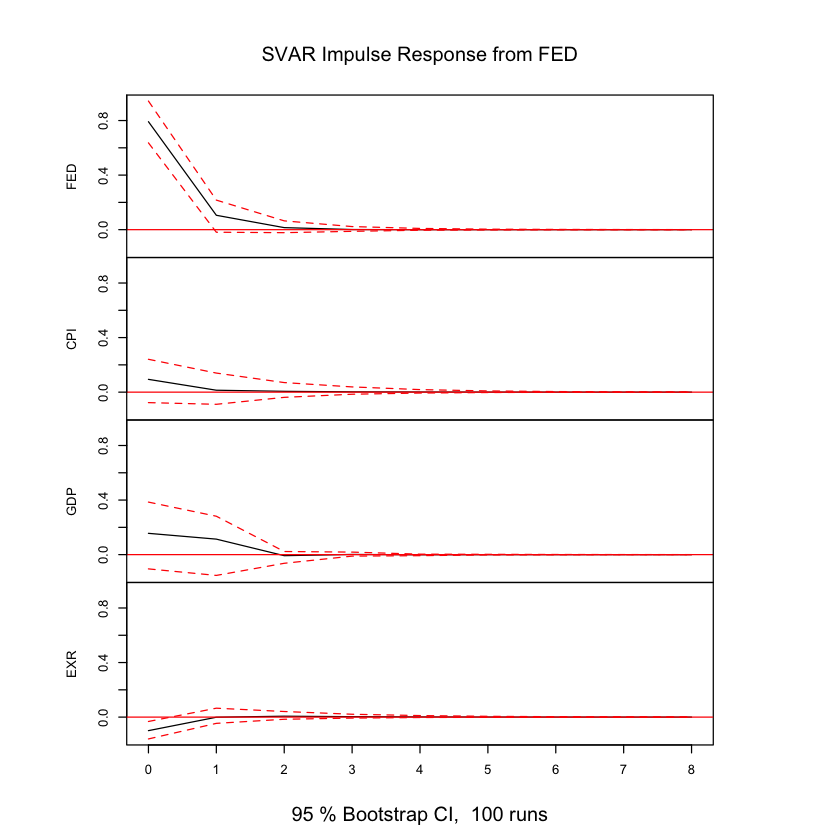

In [94]:
# re-generate IRFs:

IRFs_new <- irf(sVarModel_new, impulse = "FED", n.ahead = 8)
plot(IRFs_new)

Due to our new causal ordering, the fed rate shocks are now contemporaneously transmitted into all other variables:

- The reaction of prices is now upward, but still not significant.
- GDP also increases contemporaneously, but not significantly.
- The exchange rate is now negatively affected, where the initial drop is significant. 

The effect on the exchange rate, which is the only significant effect, is intuitive, whilst the effect on GDP and prices is counter-intuitive. Here I do observe something like a price (/output) puzzle. 
1) Either, this is no mistake, and the model is correct:

    Perhaps an increase in the short term rate is a cost push shock for firms which try to pass on the costs before convergence to a new equilibrium.

2) Or, my guess, the model is misspecified: 

    One example is that there are ommitted information variables that inform both the fed rate but also affect prices, thus confounding the (causal) policy shocks between the fed rate and prices (and gdp).

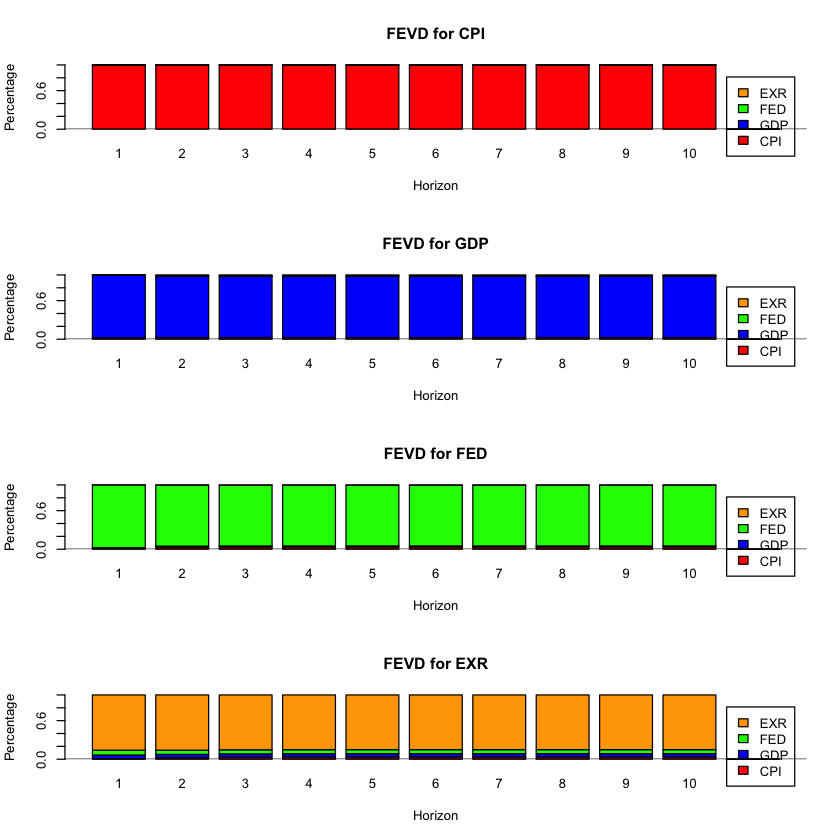

In [95]:
# Variance decompostion for the initial sVar model:
svar_fevd <- fevd(sVarModel, n.ahead = 10)
# plot the variance decomposition, with colours for the 4 variables:
plot(svar_fevd, col = c("red", "blue", "green", "orange"))

How much of the long run variation in output’s forecast is due to the
policy rate?

Basically none. This is both due to the relatively small (estimated) variance of the policy rate, the fact that the impact of a policy shock on output is not very large (insignificant even in the IRF), and the fact shocks to GDP are not very persistent (in the IRF we saw that it returns to previous level after only two quarters).